In [3]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline


Define a function that will calibrate camera distortion from all images under a directory.

failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg


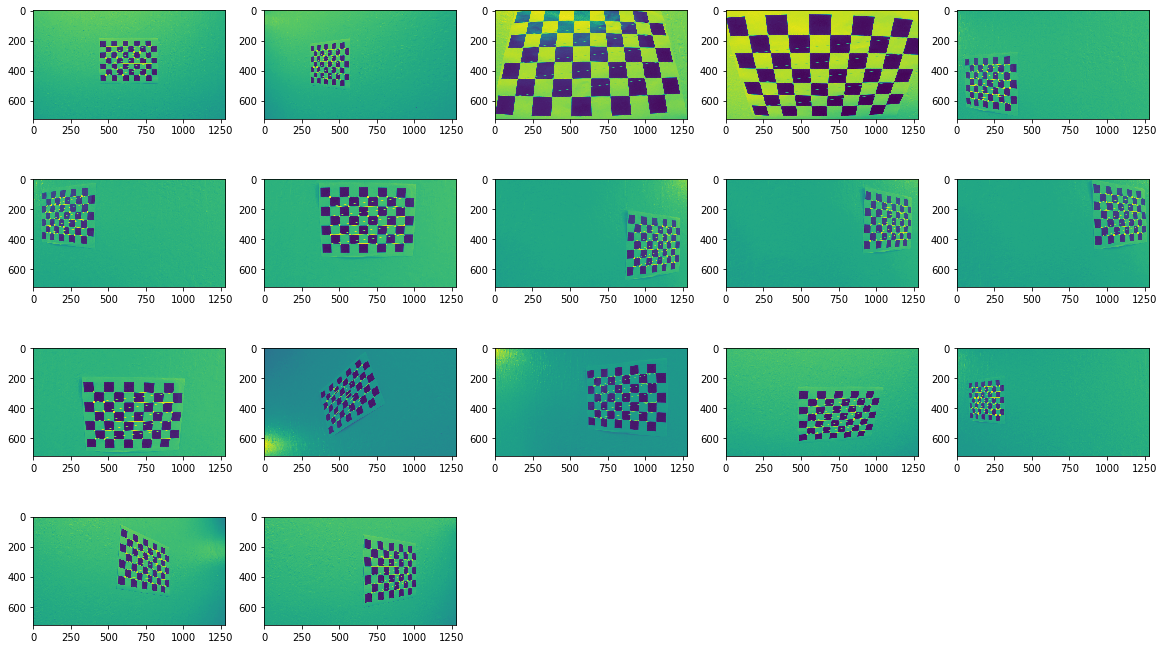

In [115]:
# ------------------------------------
# return 3D coordinates for board corners of given size
def get3DCoor(sizeBoardCorners):
    r, c = sizeBoardCorners
    tar = np.zeros((r*c, 3), np.float32)
    tar[:,:2] = np.mgrid[0:r, 0:c].T.reshape(-1, 2)
    return tar

# ------------------------------------
# find corners of all images from a directory with given corner shape, then caliculate matrix for correcting distortion
def calDistortMatrix(fileDir, sizeBoardCorners):
    calFiles = glob.glob("camera_cal/calibration*.jpg")

    corners_img = []
    corners_tar = []
    
    tarCoord = get3DCoor(sizeBoardCorners)
        
    i = 0
    for fname in calFiles:            
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        if not ret: 
            print('failled finding board from: ', fname)
            continue
        
        corners_img.append(corners)
        corners_tar.append(tarCoord)
            
        # draw the board and the found corners to make sure all are found correctly
        cv2.drawChessboardCorners(gray, sizeBoardCorners, corners, ret)
        plt.subplot(5, 5, i+1)
        plt.imshow(gray)
        i += 1
    plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(corners_tar, corners_img, gray.shape, None, None)
    return ret, mtx, dist

# ------------------------------------
plt.rcParams['figure.figsize'] = (20, 15)

sizeBoardCorners = (9, 6)
ret, mtx, dist = calDistortMatrix('camera_cal', sizeBoardCorners)

Apply the distortion correction to one of the calibration image:

Text(0.5,1,'Undistorted Image')

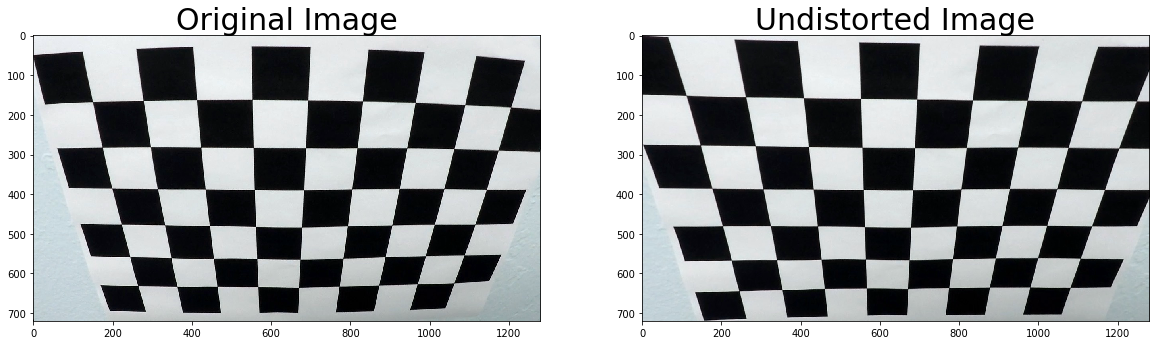

In [116]:
fn = 'camera_cal/calibration2.jpg'
img = cv2.imread(fn)
img_corrected = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corrected)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
Use color transforms, gradients, etc., to create a thresholded binary image

In [183]:
# ------------------------------------
def getGrad(img, kernelSize):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    gradx = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize = kernelSize)
    grady = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize = kernelSize)    
    return gradx, grady

# ------------------------------------
# masking based on direction of the gradient
# img BGR color image, default threshhold: 0~pi/2
def gradientDirectionMask(gradx, grady, thresh=[0, np.pi/2]):
    angle = np.arctan2(np.absolute(grady), np.absolute(gradx))
    angle = np.absolute(angle)
    
    binary_output = np.zeros_like(angle)
    binary_output[(angle >= thresh[0]) & (angle < thresh[1])] = 1    
    return binary_output

# ------------------------------------
# masking based on magnitude of the gradient, threshhold
# img BGR color image, default threshhold:0~255
def gradientMagnitudeMask(gradx, grady, thresh=[0, 255], axis='x'):
    if axis == 'x':
        gradm = np.absolute(gradx)
    else:
        gradm = np.absolute(grady)
    gradm = gradm/gradm.max()*255
    
    binary_output = np.zeros_like(gradm)
    binary_output[(gradm >= thresh[0]) & (gradm < thresh[1])] = 1    
    return binary_output
    
# ------------------------------------
# masking based on the selected channel of the HLS representation of the image
# img BGR color image, default threshhold: 0~255
def colorChannelMask(img, thresh=[0, 255], channel='S'):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    channelMap = {'H':0, 'L':1, 'S':2}
    ch = channelMap[channel]
    singleChannel = hls[:, :, ch]
    
    binary_output = np.zeros_like(singleChannel)
    binary_output[(singleChannel >= thresh[0]) & (singleChannel <= thresh[1])] = 1
    return binary_output

def regionOfInterestMask(img):
    sizy, sizx, dummy = img.shape
    roi = np.array([[sizx*0.35, sizy*0.55], [sizx*0.1, sizy*0.95], [sizx*0.8, sizy*0.95], [sizx*0.65, sizy*0.55]]).astype(int)
    
    binary_mask = np.zeros((sizy, sizx))
    cv2.fillPoly(binary_mask, [roi], 1)
    return binary_mask

    
# ------------------------------------
# Input BGR color image
# Ouput Binary map 
# binary map is a combination of masking with direction and magnitude of the gradient and s-channel of HLS representation
def findAllMasks(img):
    gradx, grady = getGrad(img, kernelSize = 3)
    
    rg_mask = (img[:,:,1] > 150) & (img[:,:,2] > 150)
    
    dir_mask = gradientDirectionMask(gradx, grady, thresh=(np.pi/6, np.pi/2))
    mag_mask = gradientMagnitudeMask(gradx, grady, thresh=(10, 200),  axis='x')
    gradient_mask = cv2.bitwise_and(dir_mask, mag_mask)
    
    roi_mask = regionOfInterestMask(img)
    
    s_mask = colorChannelMask(img, thresh=[100, 255], channel='S')
    
    return (rg_mask, gradient_mask, s_mask, roi_mask)

def mergeMasks2RGB(masks):
    return np.stack(masks, axis=2)*255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


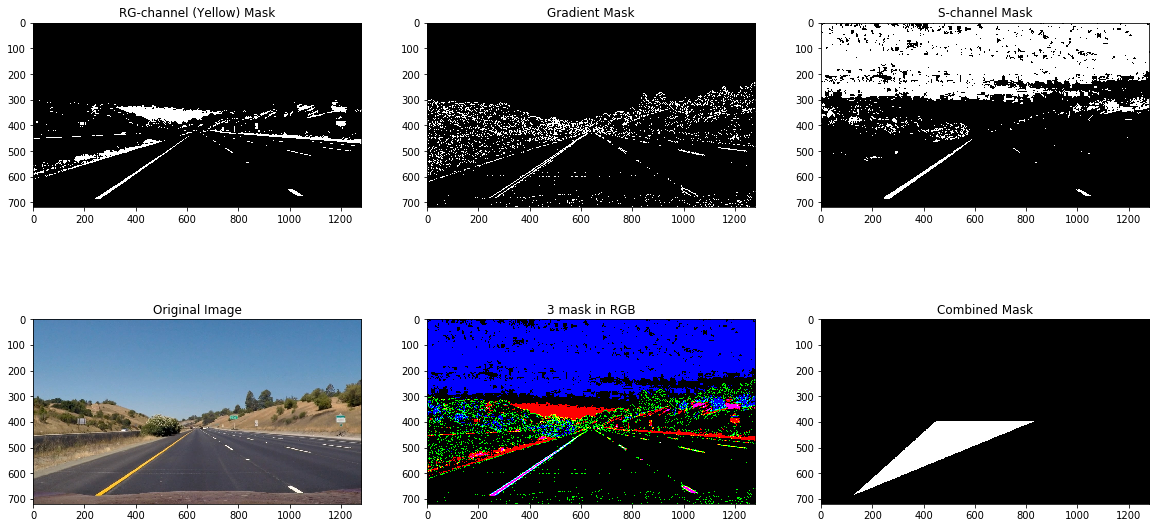

In [185]:
# ------------------------------------
plt.rcParams['figure.figsize'] = (20, 10)
testFn = 'test_images/straight_lines1.jpg'
imgTest = cv2.imread(testFn)

rg_mask, gradient_mask, s_mask, roi_mask = findAllMasks(imgTest)

# final combined mask, (direction mask && magnitude mask) || color mask
combinedMask = np.multiply(rg_mask, gradient_mask)
combinedMask = (combinedMask > 0) | (s_mask > 0)
combinedMask = np.multiply(combinedMask, roi_mask)*255

# combinedMask = cv2.bitwise_and(combinedMask, roi_mask)

# combinedMask[(masks[0]==1 )&( masks[1]==1 ) | (masks[2]==1)] = 255


f, axhandles = plt.subplots(2, 3, figsize=(20,10))

titles = ['RG-channel (Yellow) Mask', 'Gradient Mask', 'S-channel Mask']
for i in range(3):
    axhandles[0, i].imshow(masks[i]*255, cmap='gray')
    axhandles[0, i].set_title(titles[i])
    
axhandles[1, 0].imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
axhandles[1, 0].set_title('Original Image')

axhandles[1, 1].imshow(mergeMasks2RGB(masks[:3]))
axhandles[1, 1].set_title('3 mask in RGB')

axhandles[1, 2].imshow(roi_mask, cmap='gray')
axhandles[1, 2].set_title('Combined Mask')

plt.show()